In [1]:
import sys, glob, time
import collections

import numpy as np
import tensorflow as tf
import pandas as pd 

import pybullet as p
from pyb.pybullet_robot import PyBulletRobot

from matplotlib import pyplot as plt
%matplotlib inline

from utils import mk_model, live_plot, plot_fh

%load_ext autoreload
%autoreload 2

In [2]:
r = PyBulletRobot(4, 4, render=True)

*** Initializing PyBulletRobot(ns=4, render=True) ...
*** Initializing PyBulletRobot() done


In [9]:
MAX_ALPHA = np.pi/4
D_ALPHA = 0.025

def r_step6(phis):
    phis2 = phis.reshape(-1, 2)
    phis2 = np.append(phis2, [phis2[-1]], axis=0)    
    r.step(phis2)

def set_robot_pose(model, alpha):
    cam_p = [0.23, 0.0, 0.67]
    
    # getQuaternionFromEuler (the roll around the X, pitch around Y and yaw around the Z axis)
    cam_o = r.euler2orn(alpha, np.pi/2, 0)
    cam_v, cam_u = r.orn2vu(cam_o)

    cam_po = np.array(cam_p + cam_o, dtype=np.float32)
    
    phis = model.predict(np.array([cam_po]))[0]
    
    r_step6(phis)
    pvu = r.getHeadcamPVU()

    r.getCameraImage()
    return pvu, cam_po, phis, [cam_p, cam_v, cam_u]

def sweep_model(model):
    cam_pos = list()
    phiss = list()
    
    data_v = collections.defaultdict(list)
    data_u = collections.defaultdict(list)
    data_phis = collections.defaultdict(list)

    for alpha in np.arange(-MAX_ALPHA, MAX_ALPHA+D_ALPHA, D_ALPHA):
        pvu0, cam_po, phis, pvu1 = set_robot_pose(model, alpha)
        cam_pos.append(cam_po)
        phiss.append(phis)

        if True:
            data_v['cam_vx0'].append(pvu0[1][0])
            data_v['cam_vx1'].append(pvu1[1][0])
            data_v['cam_vy0'].append(pvu0[1][1])
            data_v['cam_vy1'].append(pvu1[1][1])
            data_v['cam_vz0'].append(pvu0[1][2])
            data_v['cam_vz1'].append(pvu1[1][2])

        if True:
            data_u['cam_ux0'].append(pvu0[2][0])
            data_u['cam_ux1'].append(pvu1[2][0])
            data_u['cam_uy0'].append(pvu0[2][1])
            data_u['cam_uy1'].append(pvu1[2][1])
            data_u['cam_uz0'].append(pvu0[2][2])
            data_u['cam_uz1'].append(pvu1[2][2])

        if True:
            for i in range(phis.shape[0]):
                data_phis['phi%d' % i].append(phis[i])

    return cam_pos, phiss, data_v, data_u, data_phis

### sweep the head from left to right on a horizontal plane, collect phiss for that trajectory

In [10]:
model = tf.keras.models.load_model('pose2phis-128-4-relu-5000000')
cam_pos, phiss, data_v, data_u, data_phis = sweep_model(model)

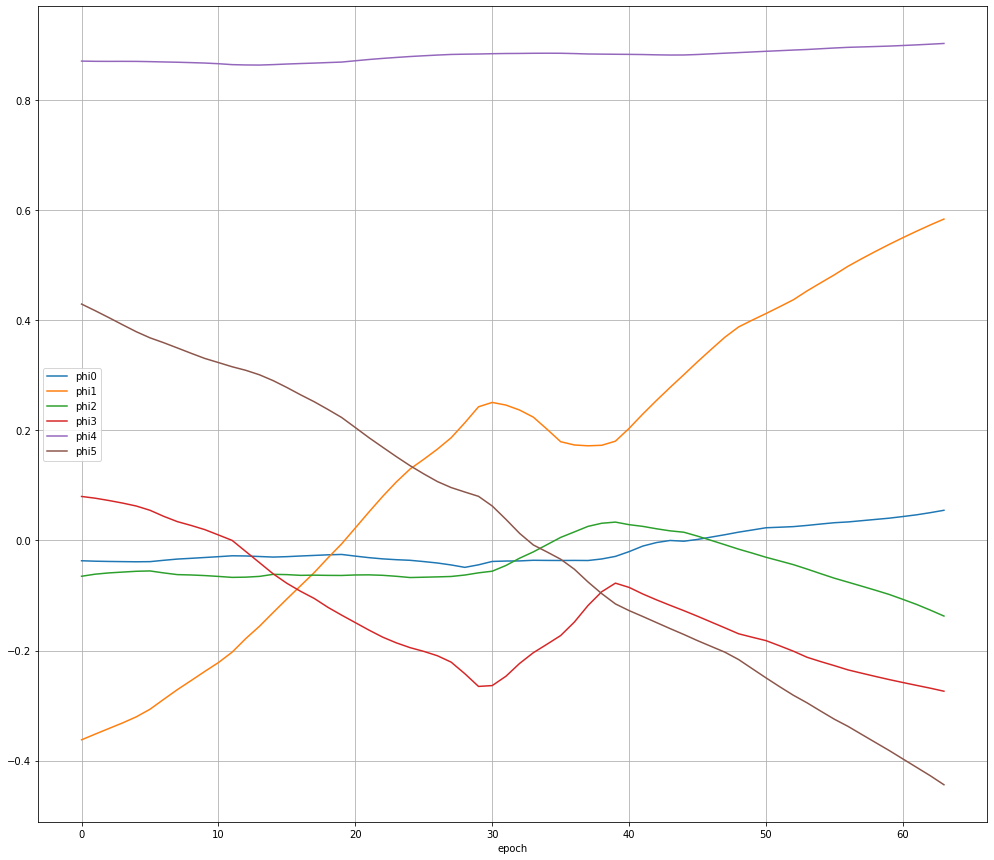

In [5]:
live_plot(data_phis)

### create new batch of phiss based on it, by adding noise

In [33]:
cam_pos2 = []
phiss2 = []
   
for phis in phiss:
    for i in range(1000):
        if i == 0:
            dphi = 0
        else:
            dphi = np.random.uniform(size=phis.shape[0])*0.001
        phis2 = phis + dphi

        r_step6(phis2)
        cam_p, cam_o = r.getHeadcamPO()
        cam_pos2.append(cam_p + cam_o)
        
        phiss2.append(phis2)
        break

cam_pos2 = np.array(cam_pos2)
phiss2 = np.array(phiss2)
cam_pos2.shape, phiss2.shape

((64, 7), (64, 6))

In [34]:
#train_data0 = np.load("xy-5000000.npz")
#X = np.vstack(train_data0['X'], cam_pos2)
#Y = np.vstack(train_data0['Y'], phiss2)
X = cam_pos2
Y = phiss2
X.shape, Y.shape

((64, 7), (64, 6))

In [37]:
phiss = np.array(phiss)
print(phiss[0])
print(Y[0])

[-0.21472406 -0.49184212  0.42276517  0.22187495  0.72451746  0.35383117]
[-0.21472406 -0.49184212  0.42276517  0.22187495  0.72451746  0.35383117]


In [38]:
model = mk_model()
#fh = model.fit(X, Y, epochs=10, shuffle=True, validation_split=0.002, verbose=1)
fh = model.fit(X, Y, epochs=5000, shuffle=True, verbose=0)

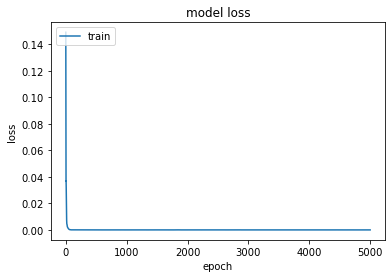

In [46]:
plot_fh(fh, plot_val_loss=False)

In [47]:
cam_pos, phiss, data_v, data_u, data_phis = sweep_model(model)

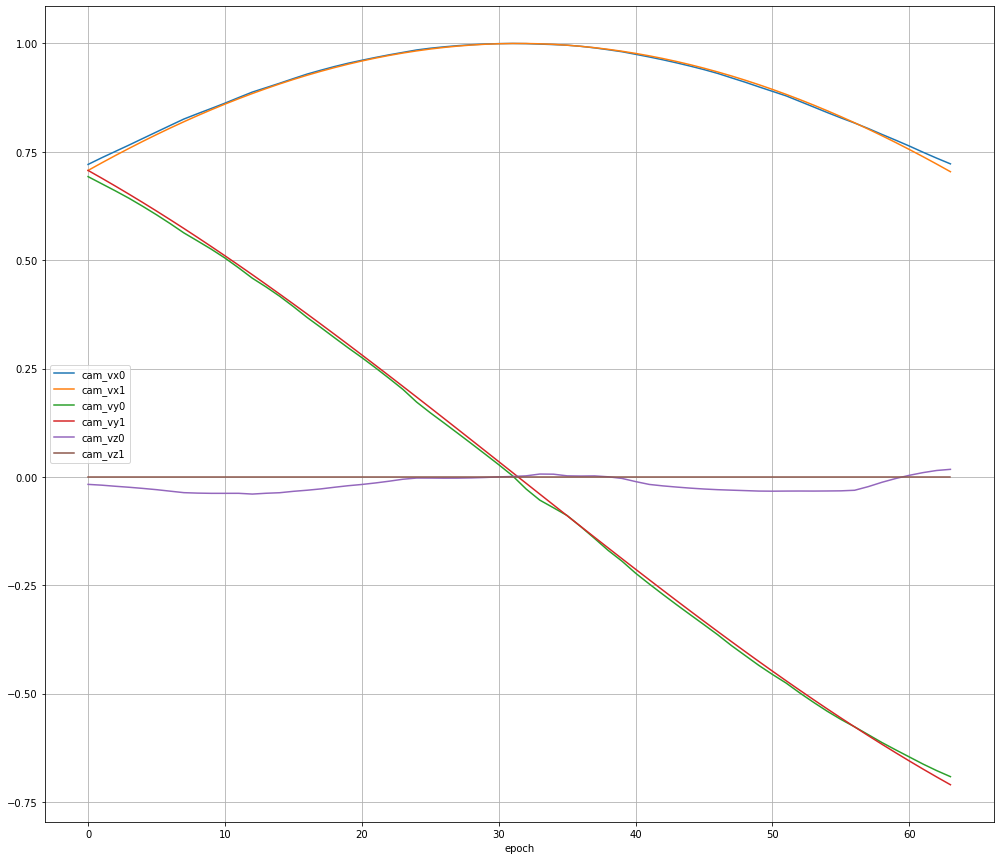

In [48]:
live_plot(data_v)